## Feedbacks visualization
Simple bar graph based on code from IH (the true OG).

In [2]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, re
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

### Check running location and adjust working directory appropriately.

In [3]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(fb_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [4]:
os.listdir(fb_dir)

['CAM61_1_1_check2',
 'CAM61_satcomp_SFC_wbf_1_inp_1',
 'CAM6_satcomp_FLDSCS_wbf_1_inp_1',
 'CAM61_satcomp_wbf_1_inp_1',
 'CAM61_1_1_GFDL_kernels',
 'CAM6_satcomp_FLTKERN_wbf_1_inp_1',
 'CAM61_test_GFDL_FLT',
 'CAM61_test_GFDL_kernels',
 'CAM61_satcomp_SFC_wbf_0.2_inp_0.1',
 'CAM61_satcomp_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFC_wbf_0.5_inp_0.05',
 'CAM6_satcomp_SFCKERN_wbf_1_inp_1',
 'CAM61_satcomp_wbf_0.5_inp_0.5',
 'CAM61_1_1_check',
 'CAM6_Fvars_check',
 'TOA_GFDL_KERNEL',
 'CAM6_satcomp_wbf_1.25_inp_10',
 'CAM6_satcomp_SFC_wbf_1.25_inp_10',
 'CAM6_satcomp_wbf_1_inp_1']

In [15]:
case_fbs = org_feedbacks_case('CAM6_satcomp_SFCKERN_wbf_1_inp_1')

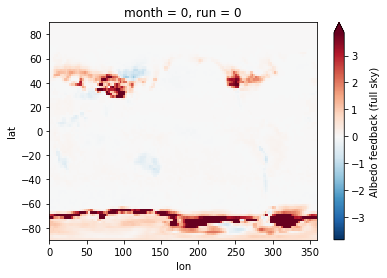

In [16]:
case_fbs['fb_albedo_ttsky'][0,:,:].plot(robust=True)

In [17]:
comp_feedbacks(case_fbs)

fb_albedo_ttsky :  0.7366018568271753
fb_cloud_sw :  1.0123458935762877
fb_cloud_lw :  0.2754140800280586
fb_adj_cloud_sw :  2.0142804824099874
fb_adj_cloud_lw :  0.48243572579106664
fb_water_vapor_sw_ttsky :  -0.17869395119882914
fb_water_vapor_lw_ttsky :  0.8311281825994268
fb_lapse_rate_ttsky :  0.10535337270375003
fb_planck_ttsky :  -0.3036732584713016
cell_weight :  0.004766985970241943


## Calculate average feedback values for the Arctic
Make sure to weight correctly by both area and month length.

In [13]:
def org_feedbacks_case(case_path):
    _fbs = os.listdir("%s/%s" % (fb_dir,case_path)) # List feedback files
    
    # Calculate the averaged Arctic quantities for each file appropriately:
    # Albedo feedback
    _albedo_file = [i for i in _fbs if "albedo_feedback" in i][0]
    _albedo = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_albedo_file)).sel(run=0))
    _albedo_vars = ['fb_albedo_ttsky']
    
    # Create a new dataset object to store specific variables within
    _all_fb = _albedo[_albedo_vars[0]].to_dataset(name=_albedo_vars[0])
    _albedo.close()
    
    # Cloud feedbacks
    _cld_file = [i for i in _fbs if "cloud_feedback" in i][0] # select file, a little clunky to avoid using regular expressions
    _cld = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_cld_file)).sel(run=0))    
    cld_vars = ["fb_cloud_sw","fb_cloud_lw","fb_adj_cloud_sw","fb_adj_cloud_lw"]
    for _var in cld_vars:
        _all_fb[_var] = _cld[_var]
    _cld.close()
    
    # Water Vapor feedback (separate files)
    _wv_sw_file = [i for i in _fbs if "water_vapor_sw" in i][0]    
    _wv_lw_file = [i for i in _fbs if "water_vapor_lw" in i][0]
    _wv_sw = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_wv_sw_file)).sel(run=0))
    _wv_lw = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_wv_lw_file)).sel(run=0))
    _wv_vars = ["fb_water_vapor_sw_ttsky", "fb_water_vapor_lw_ttsky"] # Will need to zip
    for _var,_da in zip(_wv_vars,[_wv_sw,_wv_lw]):
        _all_fb[_var] = _da[_var]
        _da.close()
        
    # Lapse Rate feedback
    _lr_file = [i for i in _fbs if "lapse_rate" in i][0]
    _lr = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_lr_file)).sel(run=0))
    _lr_vars =["fb_lapse_rate_ttsky"]
    for _var in _lr_vars:
        _all_fb[_var] = _lr[_var]
    _lr.close()
    
    # Planck feedback
    _planck_file = [i for i in _fbs if "planck_feedback" in i][0]
    _planck = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_planck_file)).sel(run=0))
    _planck_vars = ['fb_planck_ttsky']
    for _var in _planck_vars:
        _all_fb[_var] = _planck[_var]
    _planck.close()

    _all_fb = add_weights(_all_fb)
    
    return _all_fb

In [14]:
def comp_feedbacks(fb_ds):
    # Used for weighting by month. I tested this and it didn't make a big change here, but could elsewhere.
    wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
    month_length = xr.DataArray(wgt_mon, coords=[fb_ds['fb_albedo_ttsky']['month']], name='month_length')

    # This matrix cross-product will allow me to do all of my weighting in a single step.
    all_weights = month_length @ fb_ds['cell_weight']
    
    for _var in fb_ds.data_vars:
        _ds = fb_ds[_var]
        mask = _ds['lat'] < 66
        _arc_val = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
        print(_var, ": ", _arc_val.values)

In [9]:
cases = os.listdir(fb_dir)
case_dict = {} # Cases are keys, feedback dictionaries are values

# Iterate over each case
for _case in cases:
    print(_case)
    _fbs = os.listdir("%s/%s" % (fb_dir,_case)) # List feedback files
    
    # Calculate the averaged Arctic quantities for each file appropriately:
    # Albedo feedback
    _albedo_file = [i for i in _fbs if "albedo_feedback" in i][0]
    _albedo = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,_case,_albedo_file)).sel(run=0))
    _albedo_vars = ['fb_albedo_ttsky']
    
    # Create a new dataset object to store specific variables within
    _all_fb = _albedo[_albedo_vars[0]].to_dataset(name=_albedo_vars[0])
    _albedo.close()
    
    # Cloud feedbacks
    _cld_file = [i for i in _fbs if "cloud_feedback" in i][0] # select file, a little clunky to avoid using regular expressions
    _cld = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,_case,_cld_file)).sel(run=0))    
    cld_vars = ["fb_cloud_sw","fb_cloud_lw","fb_adj_cloud_sw","fb_adj_cloud_lw"]
    for _var in cld_vars:
        _all_fb[_var] = _cld[_var]
    _cld.close()
    
    # Water Vapor feedback (separate files)
    _wv_sw_file = [i for i in _fbs if "water_vapor_sw" in i][0]    
    _wv_lw_file = [i for i in _fbs if "water_vapor_lw" in i][0]
    _wv_sw = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,_case,_wv_sw_file)).sel(run=0))
    _wv_lw = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,_case,_wv_lw_file)).sel(run=0))
    _wv_vars = ["fb_water_vapor_sw_ttsky", "fb_water_vapor_lw_ttsky"] # Will need to zip
    for _var,_da in zip(_wv_vars,[_wv_sw,_wv_lw]):
        _all_fb[_var] = _da[_var]
        _da.close()
        
    # Lapse Rate feedback
    _lr_file = [i for i in _fbs if "lapse_rate" in i][0]
    _lr = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,_case,_lr_file)).sel(run=0))
    _lr_vars =["fb_lapse_rate_ttsky"]
    for _var in _lr_vars:
        _all_fb[_var] = _lr[_var]
    _lr.close()
    
    # Planck feedback
    _planck_file = [i for i in _fbs if "planck_feedback" in i][0]
    _planck = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,_case,_planck_file)).sel(run=0))
    _planck_vars = ['fb_planck_ttsky']
    for _var in _planck_vars:
        _all_fb[_var] = _planck[_var]
    _planck.close()
    
    # Save all to dictionary
    case_dict[_case] = _all_fb

CAM61_1_1_check2
CAM61_satcomp_SFC_wbf_1_inp_1
CAM61_satcomp_wbf_1_inp_1
CAM61_1_1_GFDL_kernels
CAM6_satcomp_FLTKERN_wbf_1_inp_1
CAM61_test_GFDL_FLT
CAM61_satcomp_SFC_wbf_0.2_inp_0.1
CAM61_satcomp_wbf_0.2_inp_0.1
CAM61_satcomp_SFC_wbf_0.5_inp_0.05
CAM6_satcomp_SFCKERN_wbf_1_inp_1
CAM61_satcomp_wbf_0.5_inp_0.5
CAM6_Fvars_check
TOA_GFDL_KERNEL
CAM6_satcomp_wbf_1.25_inp_10
CAM6_satcomp_SFC_wbf_1.25_inp_10
CAM6_satcomp_wbf_1_inp_1


In [10]:
# Used for weighting by month. I tested this and it didn't make a big change here, but could elsewhere.
wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
month_length = xr.DataArray(wgt_mon, coords=[_albedo['month']], name='month_length')

# This matrix cross-product will allow me to do all of my weighting in a single step.
all_weights = month_length @ _planck['cell_weight']

In [ ]:
for _var in _all_fb.data_vars:
    _ds = _all_fb[_var]
    mask = _ds['lat'] < 66
    _arc_val = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
    print(_var, ": ", _arc_val.values)

In [15]:
"SFC" in "tototSFCto"

True

In [20]:
# fig, ax = plt.subplots(figsize=(15.,4))
barvals_PL = []
barvals_LR = []
barvals_WV = []
barvals_A = []
barvals_CLSW = []
barvals_CLLW = []

cases = []
for _mod in case_dict.keys():
    print(_mod)
    _da = case_dict[_mod]

    _avg_dict = {}
    if "SFC" in _mod: # Filter SFC kernels
        cases.append(_mod)
        for _var in _da.data_vars:
            _ds = _da[_var]
            mask = _ds['lat'] < 66
            _arc_val = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
            print(_var, ": ", _arc_val.values)
            _avg_dict[_var] = _arc_val.values

        barvals_PL.append(_avg_dict['fb_planck_ttsky'])        
        barvals_LR.append(_avg_dict['fb_lapse_rate_ttsky'])
        barvals_WV.append(_avg_dict['fb_water_vapor_sw_ttsky']+_avg_dict['fb_water_vapor_lw_ttsky'])
        barvals_A.append(_avg_dict['fb_albedo_ttsky'])
        barvals_CLSW.append(_avg_dict['fb_adj_cloud_sw'])
        barvals_CLLW.append(_avg_dict['fb_adj_cloud_lw'])


CAM61_1_1_check2
CAM61_satcomp_SFC_wbf_1_inp_1
fb_albedo_ttsky :  0.7240794183630002
fb_cloud_sw :  1.1481756858434116
fb_cloud_lw :  0.4769698223488817
fb_adj_cloud_sw :  2.1338695704446793
fb_adj_cloud_lw :  0.7153192218949629
fb_water_vapor_sw_ttsky :  -0.1783508032906733
fb_water_vapor_lw_ttsky :  0.833360430696482
fb_lapse_rate_ttsky :  0.058101957851828756
fb_planck_ttsky :  -0.29755931432767446
CAM61_satcomp_wbf_1_inp_1
CAM61_1_1_GFDL_kernels
CAM6_satcomp_FLTKERN_wbf_1_inp_1
CAM61_test_GFDL_FLT
CAM61_satcomp_SFC_wbf_0.2_inp_0.1
fb_albedo_ttsky :  0.7575120030650054
fb_cloud_sw :  1.025214590153721
fb_cloud_lw :  0.41215087878993306
fb_adj_cloud_sw :  2.028188798615205
fb_adj_cloud_lw :  0.6215057090783167
fb_water_vapor_sw_ttsky :  -0.1793735255494972
fb_water_vapor_lw_ttsky :  0.836930508557352
fb_lapse_rate_ttsky :  0.04141048346811878
fb_planck_ttsky :  -0.3244737116582842
CAM61_satcomp_wbf_0.2_inp_0.1
CAM61_satcomp_SFC_wbf_0.5_inp_0.05
fb_albedo_ttsky :  0.7346363324063988
f

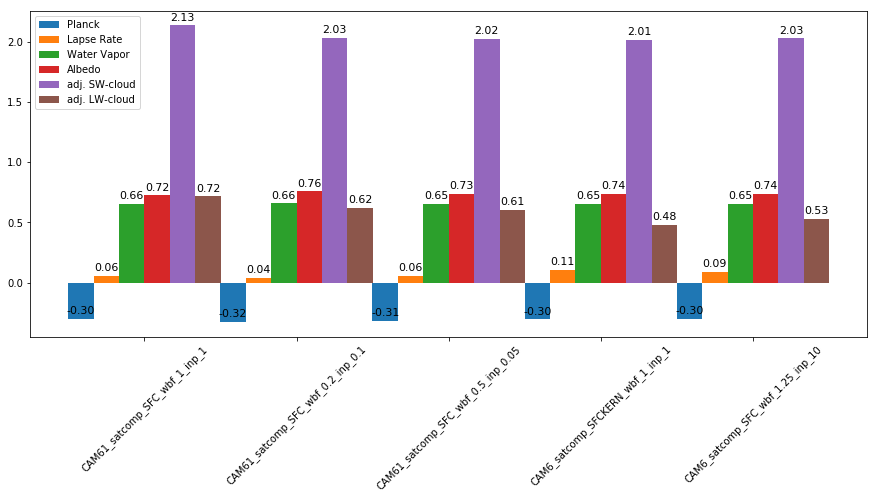

In [21]:
fig, ax = plt.subplots(figsize=(15.,6))

xind = range(len(case_dict.keys()))
xind = range(len(barvals_PL))
width = 0.167         # the width of the bars
xind_p1 = [i-(width*2.5) for i in xind]
xind_p2 = [i-(width*1.5) for i in xind]
xind_p3 = [i-(width*0.5) for i in xind]
xind_p4 = [i+(width*0.5) for i in xind]
xind_p5 = [i+(width*1.5) for i in xind]
xind_p6 = [i+(width*2.5) for i in xind]
p1 = ax.bar(xind_p1, barvals_PL, width, label='Planck')
p2 = ax.bar(xind_p2, barvals_LR, width, label='Lapse Rate')
p3 = ax.bar(xind_p3, barvals_WV, width, label='Water Vapor')
p4 = ax.bar(xind_p4, barvals_A, width, label='Albedo')
p5 = ax.bar(xind_p5, barvals_CLSW, width, label='adj. SW-cloud')
p6 = ax.bar(xind_p6, barvals_CLLW, width, label='adj. LW-cloud')

autolabel2(p1)
autolabel2(p2)
autolabel2(p3)
autolabel2(p4)
autolabel2(p5)
autolabel2(p6)
# plt.ylim(min(barvals_PL)-0.2,abs(min(barvals_PL))+0.2)

ax.set_xticks(xind)
ax.set_xticklabels(cases, rotation=45)#, fontsize=15)

ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('Planck', 'Lapse Rate', 'Water Vapor', 'Albedo', 'adj. SW-cloud', 'adj. LW-cloud'))

In [18]:
to_png(fig,"fb_barplot")

In [13]:
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' %height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=11,
                    ha='center', va='bottom')

## JShaw notes
__Albedo variables:__  
<u> fb_albedo_clrsky:</u> Clear-sky albedo feedback by grid.  
<u> fb_albedo_clrsky_glAvg:</u> Global average clear-sky albedo feedback by month.  
<u>fb_albedo_ttsky:</u> Total-sky albedo feedback by grid.  
<u>fb_albedo_ttsky_glAvg:</u> Global average total-sky albedo feedback by month.  

__Lapse Rate variables:__ (these are structured the same as albedo)  
    <u>fb_lapse_rate_clrsky</u>  
    <u>fb_lapse_rate_clrsky_glAvg</u>  
    <u>fb_lapse_rate_ttsky</u>  
    <u>fb_lapse_rate_ttsky_glAvg</u>  
__Planck feedbacks:__ also structured the same  
Long- and Short-wave water vapor feedbacks too, as well as temperature feedback 

__Cloud Feedbacks:__  
    <u>fb_cloud_sw:</u> SW cloud feedback  
    <u>fb_cloud_sw_glAvg</u> Monthly Global average SW cloud feedback  
    <u>fb_cloud_lw</u> LW cloud feedback  
    <u>fb_cloud_lw_glAvg</u> Monthly Global average LW cloud feedback  
    <u>fb_adj_cloud_sw</u> "Adjusted" SW cloud feedback  
    <u>fb_adj_cloud_sw_glAvg</u> Monthly Global average "Adjusted" SW cloud feedback  
    <u>fb_adj_cloud_lw</u> "Adjusted" LW cloud feedback  
    <u>fb_adj_cloud_lw_glAvg</u> Monthly Global average "Adjusted" LW cloud feedback  

# IH stuff for reference

In [ ]:
#++ Info:
#----------------------------------------------------
#
#       Inger Helene Hafsahl Karset
#       February 13th 2020
#
#----------------------------------------------------
#-- End info

#++ Import modules
#----------------------------------------------------
from netCDF4 import Dataset
import numpy as np
import glob
import os
from matplotlib.pylab import *
import matplotlib.colors as colors
from matplotlib.ticker import ScalarFormatter
import seaborn as sns; 
sns.set(color_codes=True,font_scale=1.5)
sns.set_style("darkgrid")
#--------------------------------------------------
#-- End import modules

In [ ]:
#++ Input, top be modified:
#--------------------------------------------------
models = ['NorESM2-LM', 'EC-Earth3-Veg', 'NorESM2-MM', 'UKESM1-0-LL']

#--------------------------------------------------
#-- End of input to be modified. Do no modify code below

# NB: values need to be updated! 
ECS_all = {'NorESM2-LM': 2.53, 'NorESM2-MM': 2.51, 'EC-Earth3-Veg': 4.37, 'UKESM1-0-LL': 5.39}
SLOPE_all = {'NorESM2-LM': -1.35, 'NorESM2-MM': -1.47, 'EC-Earth3-Veg': -0.78, 'UKESM1-0-LL': -0.66}
SUM_all = {'NorESM2-LM': -1.94, 'NorESM2-MM': -1.85, 'EC-Earth3-Veg': -1.29, 'UKESM1-0-LL': -1.0}  #++IH: NB! default is 0. modify later!!
SUM_all_adj = {'NorESM2-LM': -1.57, 'NorESM2-MM': -1.45, 'EC-Earth3-Veg': -0.83, 'UKESM1-0-LL': -0.71}  #++IH: NB! default is 0. modify later!!
PL_all = {'NorESM2-LM': -3.50, 'NorESM2-MM': -3.51, 'EC-Earth3-Veg': -3.47, 'UKESM1-0-LL': -3.41}
LR_all = {'NorESM2-LM': -0.62, 'NorESM2-MM': -0.64, 'EC-Earth3-Veg': -0.39, 'UKESM1-0-LL': -0.38}
WV_all = {'NorESM2-LM': 2.02, 'NorESM2-MM': 2.09, 'EC-Earth3-Veg': 2.01, 'UKESM1-0-LL': 1.66}
A_all = {'NorESM2-LM': 0.49, 'NorESM2-MM': 0.47, 'EC-Earth3-Veg': 0.74, 'UKESM1-0-LL': 0.62}
CLSW_all = {'NorESM2-LM': 0.17, 'NorESM2-MM': 0.26, 'EC-Earth3-Veg': 0.02, 'UKESM1-0-LL': 1.06}
CLSW_all_adj = {'NorESM2-LM': 0.28, 'NorESM2-MM': 0.37, 'EC-Earth3-Veg': 0.22, 'UKESM1-0-LL': 1.19}
CLLW_all = {'NorESM2-LM': -0.50, 'NorESM2-MM': -0.52, 'EC-Earth3-Veg': -0.20, 'UKESM1-0-LL': -0.55}
CLLW_all_adj = {'NorESM2-LM': -0.24, 'NorESM2-MM': -0.23, 'EC-Earth3-Veg': 0.06, 'UKESM1-0-LL': -0.39}

In [ ]:
# Plot barplots showing ECS and TCR together
ECS_all_sorted = {f:ECS_all[f] for f in sorted(ECS_all, key=ECS_all.__getitem__)} 
#figure(num = 1, figsize = (6.,3.))
fig, ax = plt.subplots(figsize=(15.,4))
xind_tmp = range(len(ECS_all_sorted))
xind = [i*1.05 for i in xind_tmp]
#barvals1 = list(ECS_all_sorted.values()) 
barvals_PL = []
barvals_LR = []
barvals_WV = []
barvals_A = []
barvals_CLSW = []
barvals_CLLW = []
for modelname in list(ECS_all_sorted.keys()):
    #print('modelname = ', modelname)
    #print('TCR = ', TCR_all[modelname])
    barvals_PL.append(PL_all[modelname])
    barvals_LR.append(LR_all[modelname])
    barvals_WV.append(WV_all[modelname])
    barvals_A.append(A_all[modelname])
    barvals_CLSW.append(CLSW_all_adj[modelname])
    barvals_CLLW.append(CLLW_all_adj[modelname])

width = 0.167         # the width of the bars
xind_p1 = [i-(width*2.5) for i in xind]
xind_p2 = [i-(width*1.5) for i in xind]
xind_p3 = [i-(width*0.5) for i in xind]
xind_p4 = [i+(width*0.5) for i in xind]
xind_p5 = [i+(width*1.5) for i in xind]
xind_p6 = [i+(width*2.5) for i in xind]
p1 = ax.bar(xind_p1, barvals_PL, width, label='Planck')
p2 = ax.bar(xind_p2, barvals_LR, width, label='Lapse Rate')
p3 = ax.bar(xind_p3, barvals_WV, width, label='Water Vapor')
p4 = ax.bar(xind_p4, barvals_A, width, label='Albedo')
p5 = ax.bar(xind_p5, barvals_CLSW, width, label='adj. SW-cloud')
p6 = ax.bar(xind_p6, barvals_CLLW, width, label='adj. LW-cloud')
#print(xind)
#print(width)
#xind_width = [i+width for i in xind]
#xind_width05 = [i+(width*0.5) for i in xind]
#ax.set_xticks(xind_width05)
ax.set_xticks(xind)
ax.set_xticklabels(list(ECS_all_sorted.keys()), rotation=45)
ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('Planck', 'Lapse Rate', 'Water Vapor', 'Albedo', 'adj. SW-cloud', 'adj. LW-cloud'))

In [ ]:
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' %height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=11,
                    ha='center', va='bottom')
autolabel2(p1)
autolabel2(p2)
autolabel2(p3)
autolabel2(p4)
autolabel2(p5)
autolabel2(p6)
plt.ylim(min(barvals_PL)-0.2,abs(min(barvals_PL))+0.2)
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1.0), fontsize=16)
title('CMIP6; Feedbacks (years 141-150)')
ylabel('[Wm$^{-2}$K$^{-1}$]')
savefig('Feedbacks_all', bbox_inches='tight')
close(1)